<h1> Problem Statement </h1>

Your client is an Insurance company that has provided Health Insurance to its customers, now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.


In [35]:
!pip install imblearn

In [5]:
!pip install --upgrade --user numpy

Requirement already up-to-date: numpy in c:\users\skillup 49\anaconda3\lib\site-packages (1.19.2)


In [8]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn import metrics
from sklearn.preprocessing import Normalizer 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from xgboost import XGBRFClassifier,XGBClassifier

In [2]:
sns.__version__

'0.11.0'

In [10]:
data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [11]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Pre-Processing

In [12]:
data.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)


In [13]:
data.Vehicle_Age.value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [14]:
Response=data['Response']
Data=data.drop('Response',axis=1)

In [16]:
Data['Train']=1


In [17]:
Data.shape

(381109, 11)

In [18]:
test.shape

(127037, 10)

In [19]:
Data=pd.concat([Data,test],axis=0)

In [20]:
Data.Train.replace(np.NaN,0,inplace=True)

Data Encoding

In [21]:
dictionary={"Gender":{"Male":1,"Female":0},
          "Vehicle_Damage":{"Yes":1,"No":0} }
Data.replace(dictionary,inplace=True)

In [22]:
Data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Train
0,1,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1.0
1,1,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,1.0
2,1,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1.0
3,1,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,1.0
4,0,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,1.0


In [23]:
Vehicle_Age=pd.get_dummies(Data.Vehicle_Age)

In [24]:
Vehicle_Age.drop('> 2 Years',axis=1,inplace=True)

In [25]:
Data.drop('Vehicle_Age',axis=1,inplace=True)


In [26]:
Data=pd.concat([Data,Vehicle_Age],axis=1)


Check for Missing Values

In [27]:
Data.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Train                   0
1-2 Year                0
< 1 Year                0
dtype: int64

Seperating Train & Test data

In [28]:
data=Data[Data.Train==1].copy()
test=Data[Data.Train==0].copy()

In [29]:
data.drop('Train',axis=1,inplace=True)

In [30]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,1-2 Year,< 1 Year
0,1,44,1,28.0,0,1,40454.0,26.0,217,0,0
1,1,76,1,3.0,0,0,33536.0,26.0,183,1,0
2,1,47,1,28.0,0,1,38294.0,26.0,27,0,0
3,1,21,1,11.0,1,0,28619.0,152.0,203,0,1
4,0,29,1,41.0,1,0,27496.0,152.0,39,0,1


In [32]:
cols=['Gender','Driving_License','Previously_Insured','Vehicle_Damage','1-2 Year','< 1 Year']
n_cols=['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']


In [33]:
n_data=data[n_cols]
c_data=data[cols]

In [34]:
nt_data=test[n_cols]
ct_data=test[cols]

In [35]:
nrml=Normalizer()
n_data=pd.DataFrame(nrml.fit_transform(n_data),columns=n_cols)
nt_data=pd.DataFrame(nrml.transform(nt_data),columns=n_cols)

In [36]:
n_data.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
0,0.001088,0.000692,0.999985,0.000643,0.005364
1,0.002266,0.000089,0.999982,0.000775,0.005457
2,0.001227,0.000731,0.999999,0.000679,0.000705
3,0.000734,0.000384,0.999960,0.005311,0.007093
4,0.001055,0.001491,0.999982,0.005528,0.001418


In [37]:
nt_data.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
0,0.000699,0.000307,0.999990,0.004247,0.001481
1,0.001185,0.000829,0.999994,0.000207,0.003288
2,0.001174,0.000699,0.999982,0.003096,0.004969
3,0.000642,0.000723,0.999979,0.004069,0.005006
4,0.000457,0.000474,0.999984,0.002572,0.005026


In [38]:
data=pd.concat([n_data,c_data],axis=1)
test=pd.concat([nt_data,ct_data],axis=1)

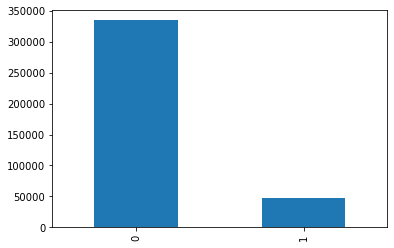

In [242]:
Response.value_counts().plot(kind='bar')

87:13 , i.e for every 8 people there are 7 non responsive and 1 responsive.

## Approach for Model Development

In [41]:
X=data
y=Response

#### Treating Imbalanced Dataset via Over-Sampling

In [42]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

#### Splitting the Dataset into Train and Validation

In [43]:
X_train,X_val,y_train,y_val=tts(X,y,test_size=.20,random_state=42)

In [44]:
y_train.value_counts()

0    267624
1    267414
Name: Response, dtype: int64

In [45]:
y_val.value_counts()

1    66985
0    66775
Name: Response, dtype: int64

#### Identifying Potential Model

In [38]:
train_data=pd.concat([X_train,y_train],axis=1)

In [39]:
train_data.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Driving_License,Previously_Insured,Vehicle_Damage,1-2 Year,< 1 Year,Response
609268,0.001389,0.000119,0.999943,0.004930,0.009408,1,1,0,1,1,0,1
13455,0.001436,0.001468,0.999996,0.000957,0.001787,0,1,1,1,1,0,0
410563,0.001139,0.000201,0.999994,0.000700,0.003088,0,1,0,1,1,0,1
496996,0.000712,0.000566,0.999996,0.002482,0.000786,1,1,0,1,1,0,1
184109,0.001671,0.001137,0.999969,0.004145,0.006451,1,1,1,0,1,0,0


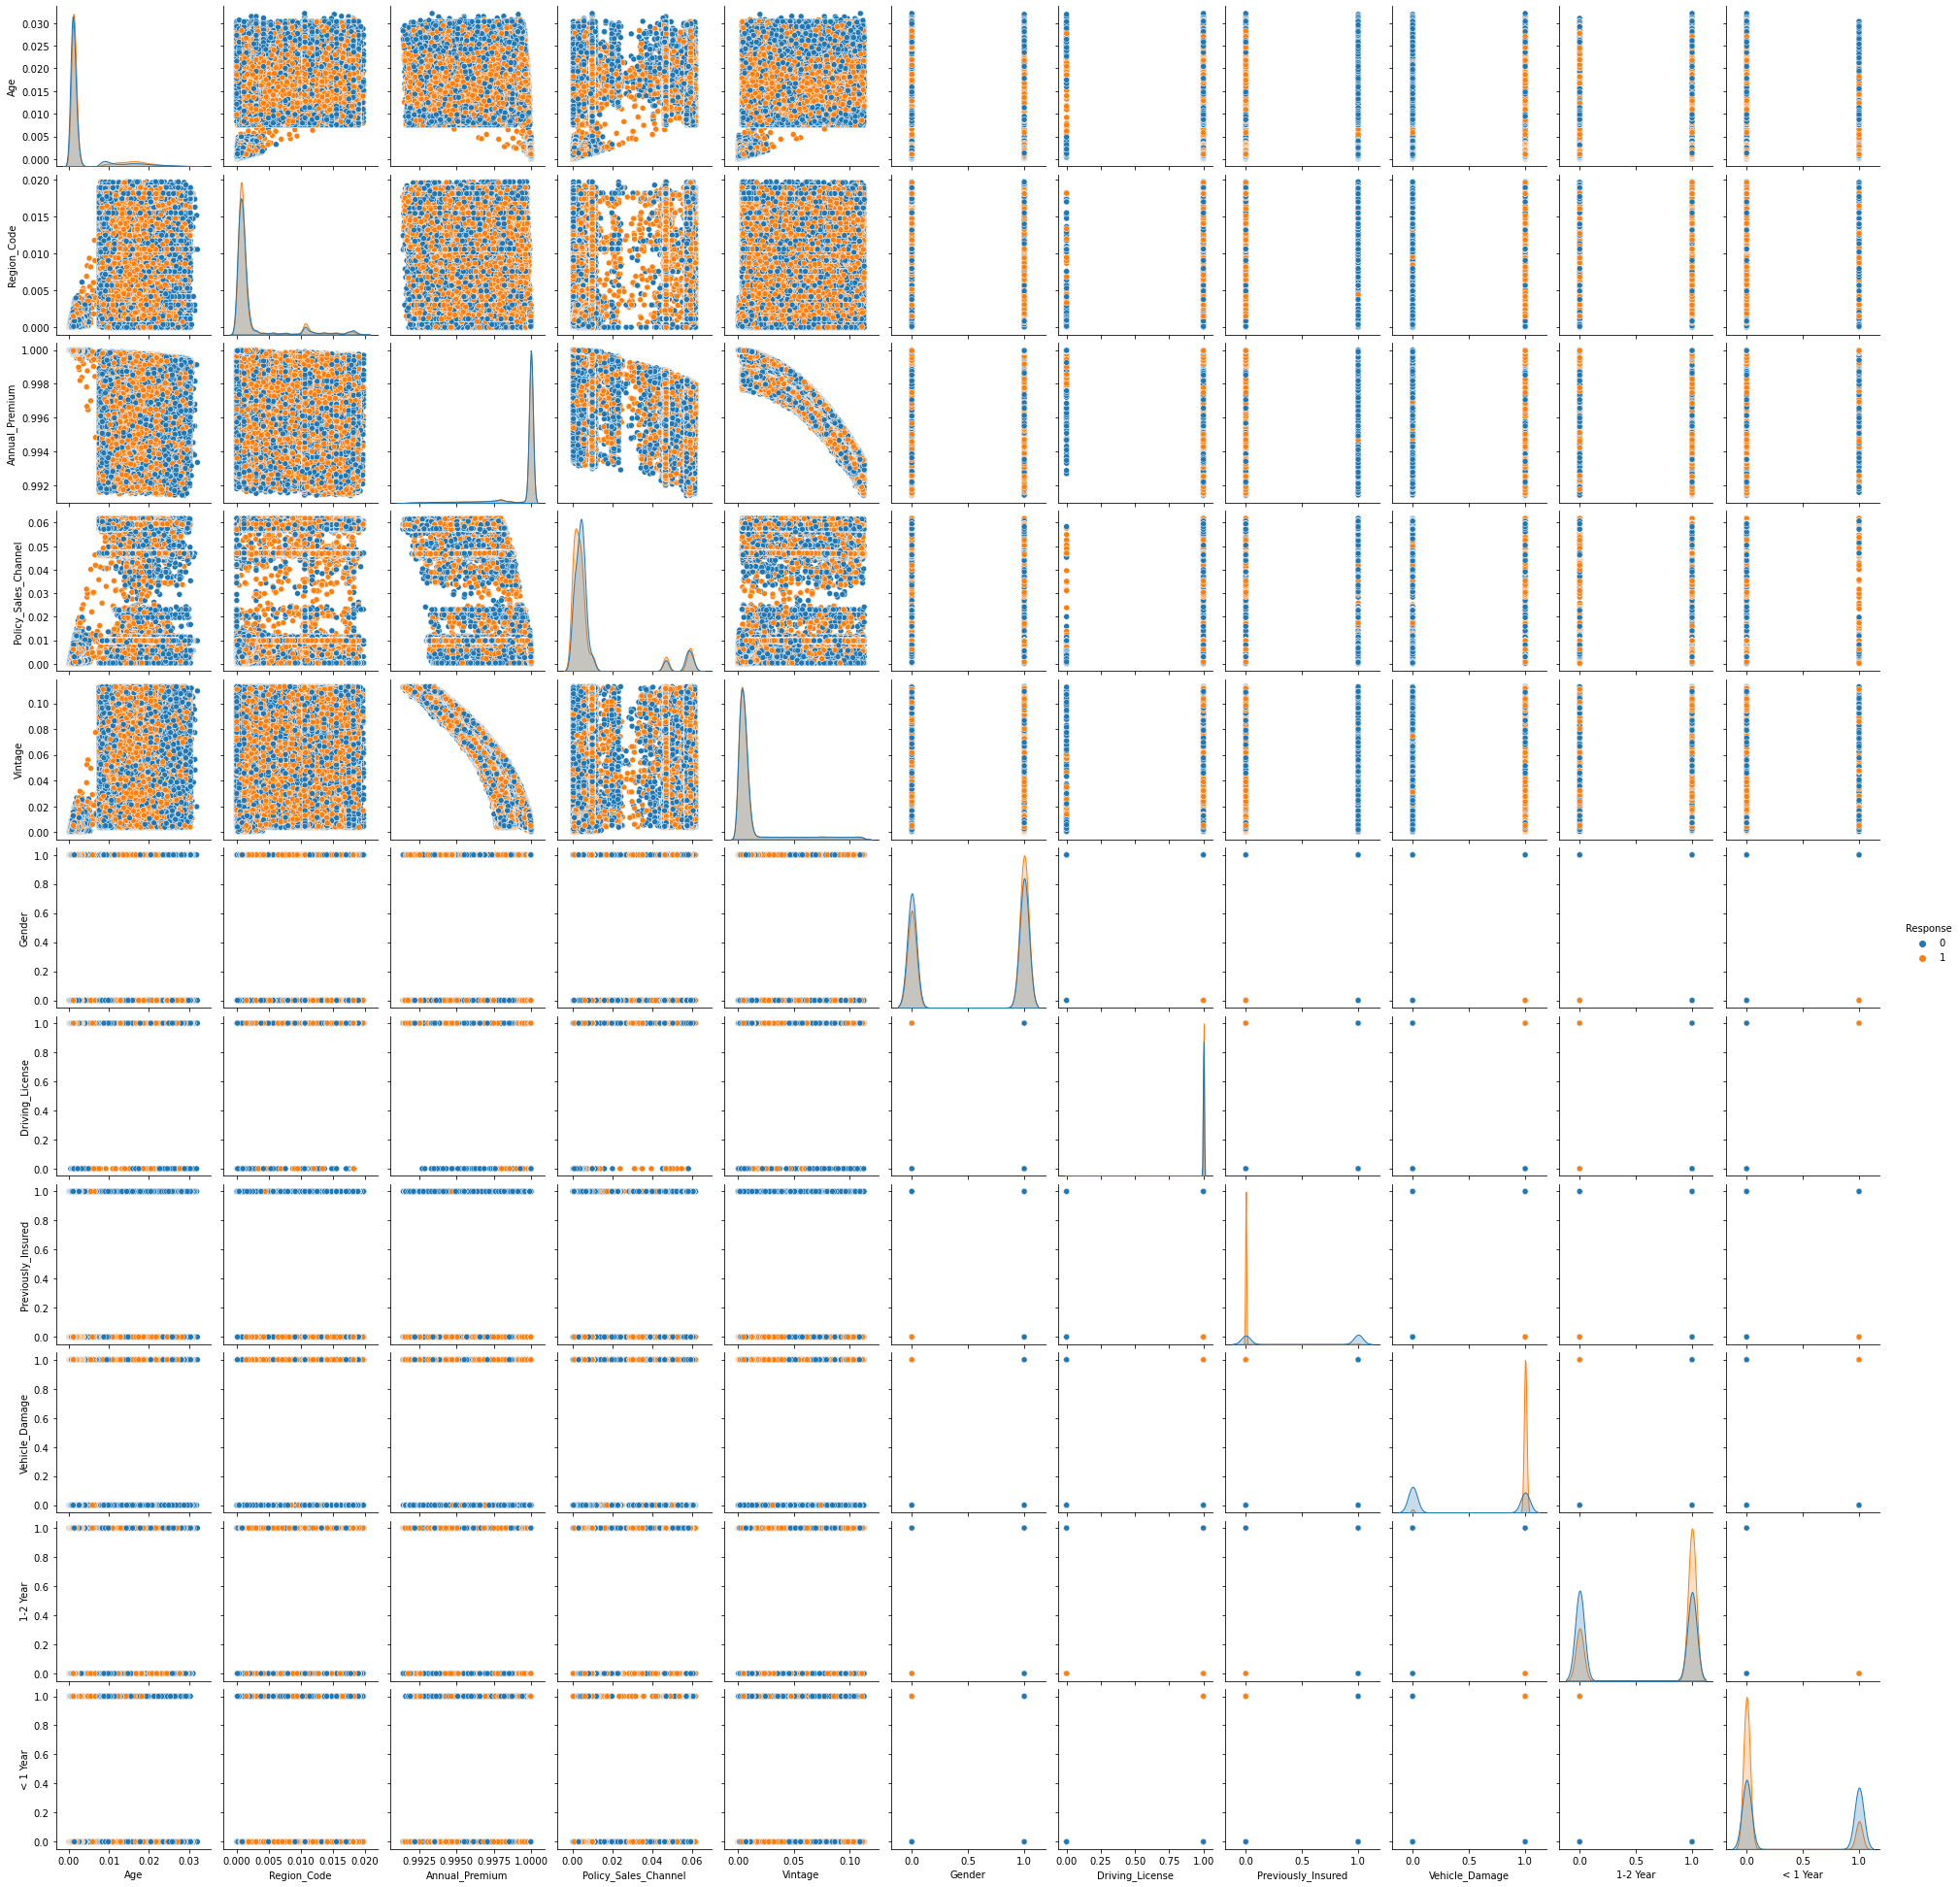

In [60]:
sns.pairplot(train_data,hue='Response')

We can see that for this kind of dataset logistic regression won't be suitable as it divides the classes via straight line , or hyper-plane, i.e it is linear in nature. This datsets have overlapping and linear classification won't be a good model for it. Models like KNN, Decision Tree, SVM ,etc are non linear classification model. Out of these SVM is not suitable as the length of dataset is large and hence it will be prone to over-fit and also it will take lot of time to execute , hence it is computationally costly. But if it had been a smaller length data , SVM would have been ideal model for this kind of data if you see the overlapping of the data. There are further more fancier models like ensemble techniques like Random Forest , XGBOOST, GBM, etc. We shall start with the basic ones first , if we do not get any suitable model we shall implement any suitable model of these.

#### KNN - Identifying Optimal K-value

In [46]:
K = [3,5,7,9] 
training = [] 
test = [] 
scores = {} 
for k in K: 
    clf = KNC(n_neighbors = k) 
    clf.fit(X_train, y_train) 
    training_score=clf.score(X_train,y_train)
    test_score = clf.score(X_val,y_val) 
     
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score] 

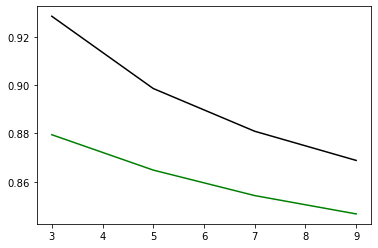

In [47]:
plt.plot(K, training, color ='k') 
plt.plot(K, test, color ='g') 
plt.show()

You can see that the accuracy slightly drops post 3rd neighbor for training set and validation set increases.Accuracy on training set dips slightly when neighbors=9, best in terms of accuracy when neighhbors =7

In [50]:
clf = KNC(n_neighbors=5) 
clf.fit(X_train, y_train) 
train_pred=clf.predict(X_train)
val_pred=clf.predict(X_val)

##### Train Log Loss

In [51]:
metrics.accuracy_score(y_train,train_pred)

3.5014135168842255

##### Test Log Loss

In [52]:
metrics.accuracy_score(y_val,val_pred)

4.668616335622487

##### Confusion Matrix

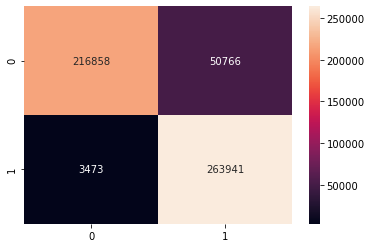

In [53]:
sns.heatmap(metrics.confusion_matrix(y_train,train_pred),annot=True,fmt='g')

A confusion matrix is nothing just a table which tells you how many samples were missclassified and how many were classified correctly.

0-N

1-P

TP=263941 ; Predicted Response =1 and actual Response =1

FP=50766 ; Predicted Response =1 and actual Response =0

TN=216858 ; Predicted Response =0 and actual Response =0

FN=3473 ; Predicted Response =0 and actual Response =1

##### Classification Report

In [54]:
print(metrics.classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89    267624
           1       0.84      0.99      0.91    267414

    accuracy                           0.90    535038
   macro avg       0.91      0.90      0.90    535038
weighted avg       0.91      0.90      0.90    535038



- Here macro average for both precision and recall is nothing just , they are calculated for both the classes and is being averaged

- Weighted average precision and recall is same as macro but in this case, it is weighted average depending on number of items in each class

##### Classification Report - Validation Set

In [56]:
print(metrics.classification_report(y_val,val_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     66775
           1       0.80      0.97      0.88     66985

    accuracy                           0.86    133760
   macro avg       0.88      0.86      0.86    133760
weighted avg       0.88      0.86      0.86    133760



As you can see we are not having high precision for both training and validation for Response=1, we need to reduce the False Positive, Hence I suggest that we can go try further models which are suitable for this type of dataset is : tree , svm-radial kernel or polynomial kernel

# Decision Tree ( Base Model)

In [430]:
dcb_clf=DTC(random_state=42)
dcb_clf.fit(X_train,y_train)
train_pred=dcb_clf.predict(X_train)
val_pred=dcb_clf.predict(X_val)


##### Accuracy

In [431]:
print("Train Accuracy {0}".format(metrics.accuracy_score(y_train,train_pred)))
print("Validation Accuracy {0}".format(metrics.accuracy_score(y_val,val_pred)))

Train Accuracy 0.9999271079811154
Validation Accuracy 0.828431519138756


##### Classification Report

In [432]:
print("Training Classification Report")
print(metrics.classification_report(y_train,train_pred))

Training Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267624
           1       1.00      1.00      1.00    267414

    accuracy                           1.00    535038
   macro avg       1.00      1.00      1.00    535038
weighted avg       1.00      1.00      1.00    535038



##### Classification Report - Validation

In [433]:
print("Validation Classification Report")
print(metrics.classification_report(y_val,val_pred))

Validation Classification Report
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     66775
           1       0.82      0.84      0.83     66985

    accuracy                           0.83    133760
   macro avg       0.83      0.83      0.83    133760
weighted avg       0.83      0.83      0.83    133760



- min_samples_leaf : 1-20

- min_samples_split : 1- 40

- min_weight_fraction_leaf: used when imbalanced data is there , imbalanced data can either be sampled or normalize the sum of the sample weights for each class. 

- max_features : 
        
        - If “auto”, then max_features=sqrt(n_features).
 
        - If “sqrt”, then max_features=sqrt(n_features).

        - If “log2”, then max_features=log2(n_features).

        - If None, then max_features=n_features.
        
         by choosing a reduced number of features we can increase the stability of the tree and reduce variance and over-fitting. if you have a high computational cost or you have a lot of overfitting, you can try with “log2” and depending on what that produces, you can either bring it slightly up using sqrt or take it down further using a custom float value.
         
- class_weight: weight * (the number of samples from a class in the node) / (size of class). 

                class_weight is a dictionary that defines each class label (e.g. 0 and 1) and the weighting to apply in the calculation of group purity for splits in the decision tree when fitting the model.
               ```
                weights = {0:1.0, 1:1.0}
                model = DecisionTreeClassifier(class_weight=weights)
               ```
               A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset.

               For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The invert of this ratio could be used with 1 for the majority class and 100 for the minority class.
               
               ```
               weights = {0:1.0, 1:100.0}
               model = DecisionTreeClassifier(class_weight=weights)
               ```

         

### Tuning Decision Tree with max_depth: 



In [440]:
max_depths=np.arange(1,100)
train_results = []
val_results = []
for max_depth in max_depths:
    dt = DTC(max_depth=max_depth,criterion='entropy',max_features="sqrt",random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    val_pred = dt.predict(X_val)
    train_score=metrics.accuracy_score(y_train,train_pred)
    val_score=metrics.accuracy_score(y_val,val_pred)
    train_results.append(train_score)
    val_results.append(val_score)
    
    
    

##### Training Loss vs Validation Loss - Max-Depth

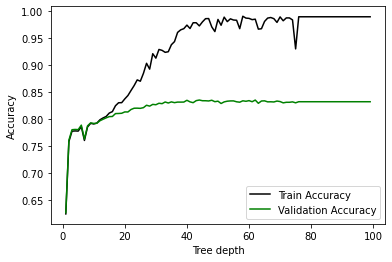

In [441]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depths, train_results, color='k', label="Train Accuracy")
line2 = plt.plot(max_depths, val_results, color='g', label="Validation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

We see that till max_depth of around 11 - 15, both training and validation loss are decreasing and similar

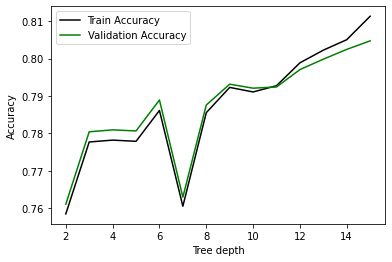

In [442]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depths[1:15], train_results[1:15], color='k', label="Train Accuracy")
line2 = plt.plot(max_depths[1:15], val_results[1:15], color='g', label="Validation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

At max_depth =11 our models loss is similar , post validation loss increases

In [443]:
dc_clf=DTC(criterion='entropy',max_depth=12,max_features="sqrt",random_state=42)
dc_clf.fit(X_train,y_train)
train_pred=dc_clf.predict(X_train)
val_pred=dc_clf.predict(X_val)

In [444]:
print("Train Accuracy {0}".format(metrics.accuracy_score(y_train,train_pred)))
print("Validation Accuracy {0}".format(metrics.accuracy_score(y_val,val_pred)))

Train Accuracy 0.7988759676882764
Validation Accuracy 0.7970693779904306


In [445]:
print("Training Classification Report")
print(metrics.classification_report(y_train,train_pred))

Training Classification Report
              precision    recall  f1-score   support

           0       0.92      0.66      0.77    267624
           1       0.73      0.94      0.82    267414

    accuracy                           0.80    535038
   macro avg       0.82      0.80      0.79    535038
weighted avg       0.82      0.80      0.79    535038



In [446]:
print("Validation Classification Report")
print(metrics.classification_report(y_val,val_pred))

Validation Classification Report
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     66775
           1       0.73      0.94      0.82     66985

    accuracy                           0.80    133760
   macro avg       0.82      0.80      0.79    133760
weighted avg       0.82      0.80      0.79    133760



We have improved on overfitting , let us try tuning it further if we can tune using min_sample_leaf/min_sample_split , objective is to reduce the loss below 6

### Tuning Decision Tree : min_sample_split

In [408]:
min_sample_splits=np.arange(2,100)
train_results = []
val_results = []
for min_sample_split in min_sample_splits:
    dt = DTC(max_depth=12,criterion='entropy',min_samples_split=min_sample_split,max_features="sqrt",random_state=42)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    val_pred = dt.predict(X_val)
    train_score=metrics.accuracy_score(y_train,train_pred)
    val_score=metrics.accuracy_score(y_val,val_pred)
    
    train_results.append(train_score)
    val_results.append(val_score)
    
    
    

##### Train Loss vs Validation Loss - Minimum Sample Split

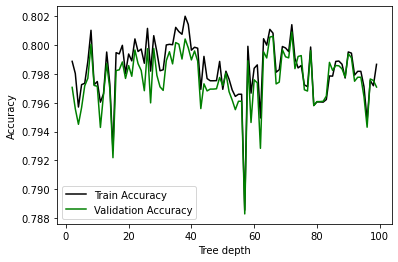

In [409]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(min_sample_splits, train_results, color='k', label="Train Accuracy")
line2 = plt.plot(min_sample_splits, val_results, color='g', label="Validation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

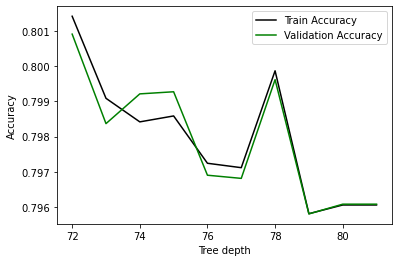

In [425]:
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(min_sample_splits[70:80], train_results[70:80], color='k', label="Train Accuracy")
line2 = plt.plot(min_sample_splits[70:80], val_results[70:80], color='g', label="Validation Accuracy")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

In [426]:
dc_clf=DTC(criterion='entropy',max_depth=12,min_samples_split=72,max_features="sqrt",random_state=42)
dc_clf.fit(X_train,y_train)
train_pred=dc_clf.predict(X_train)
val_pred=dc_clf.predict(X_val)

In [427]:
print("Train Accuracy {0}".format(metrics.accuracy_score(y_train,train_pred)))
print("Validation Accuracy {0}".format(metrics.accuracy_score(y_val,val_pred)))

Train Accuracy 0.8014197122447377
Validation Accuracy 0.8009120813397129


In [428]:
print("Training Classification Report")
print(metrics.classification_report(y_train,train_pred))

Training Classification Report
              precision    recall  f1-score   support

           0       0.91      0.67      0.77    267624
           1       0.74      0.94      0.83    267414

    accuracy                           0.80    535038
   macro avg       0.83      0.80      0.80    535038
weighted avg       0.83      0.80      0.80    535038



In [429]:
print("Validation Classification Report")
print(metrics.classification_report(y_val,val_pred))

Validation Classification Report
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     66775
           1       0.74      0.94      0.82     66985

    accuracy                           0.80    133760
   macro avg       0.82      0.80      0.80    133760
weighted avg       0.82      0.80      0.80    133760



- Few things to notedown :

    1.  For Training :Model is correct 73% times when it is trying to identify Response = 1 & it's correct 92% times when identifying Response = 0 . For Insurance industry, we need to reduce False Negative. We should not focus on the False Positive for this industry because you need to correctly predict that your customer would buy this vehicle insurance along with health insurance or not , i.e you need to correctly identify customers who will be interested to opt for vehicle insurance while purchasing health insurance, if you classify them wrongly as negative then you might loose out on that customer, so that the company can run proper marketing campaign and get higher conversion. Hence instead of precision we should focus on **Recall**
    
    1a. For Training  : Our model correctly predicted / identified 94% of positive samples , i.e where Response=1, correctly. Hence you can see for Response=1 the false negatives are quite less. For Response = 0 we do have less correct prediction, i.e 66%. But our goal was to Reduce the False Negative for Response=1. Which I believe we have done a good job.
    

    2. For Validation :Model is correct 73% times when it is trying to identify Response = 1 & it's correct 91% times when identifying Response = 0  
    
    2a. For Validation  : Our model correctly predicted / identified 94% of positive samples , i.e where Response=1, correctly.
 

## Cherry on the Top

In [88]:
X=data
y=Response

In [284]:
#Exceptions
class PredFailed(Exception):
    pass
class Model_Type(Exception):
    pass

In [390]:

class Model:
    def __init__(self,X,y,model='DTC',test_split=.20,random_state=42,model_type='balanced',k_neighbors=3,min_sample_split=2,max_depth=75,max_features='sqrt',class_weight=None):
        '''
        X - Independent Data Set
        y - Target Variable
        model - Which model to use of Decision Tree or KNN
        test_split - size of split 
        random_state 
        model_type - balanced or imbalanced
        if KNN:
            k_neighbors=number of neighbors for KNN Classifier. It must be an Odd value
        else for Decision Tree:
            min_sample_split - minimum number of samples required to split internal node
            max_depth - Maximum depth of tree
            max_features - The number of features to consider when looking for the best split: 'auto','sqrt','log2',int
            class_weight - class_weight is a dictionary that defines each class label (e.g. 0 and 1) and the weighting to apply in the calculation of group purity for splits in the decision tree when fitting the model. : 'balanced' or dictionary
            
        
        
        '''
        self.test_split=test_split
        self.random_state=random_state
        self.model_type=model_type
        self.X=X
        self.y=y
        self.k_neighbors=k_neighbors
        self.min_sample_split=min_sample_split
        self.max_depth=max_depth
        self.max_features=max_features
        self.class_weight=class_weight
        self.model=model
        self.Model={'DTC':DTC(min_samples_split=self.min_sample_split,max_depth=self.max_depth,max_features=self.max_features,class_weight=self.class_weight,random_state=self.random_state),
                   'KNN':KNC(n_neighbors=self.k_neighbors)}
        self.X_train,self.X_val,self.y_train,self.y_val=self.split()
        self.clf=self.create_model()
        
    def split(self):
        if self.model_type=="imbalanced" or self.model_type=="Imbalanced" :
            oversample = SMOTE()
            X, y = oversample.fit_resample(self.X, self.y)
            X_train,X_val,y_train,y_val=tts(X,y,test_size=self.test_split,random_state=self.random_state)
            return X_train,X_val,y_train,y_val
        elif self.model_type=="balanced" or self.model_type=="Balanced":
            
            X_train,X_val,y_train,y_val=tts(self.X,self.y,test_size=self.test_split,random_state=self.random_state)
            return X_train,X_val,y_train,y_val
        else:
            raise Model_Type("Kindly Specify the Mode Type : Balanced / Imbalanced")
    def create_model(self):
        '''
        Used to create model object and fit them with the data.
        Fetch the model from the Model dictionary
        '''
        clf=self.Model.get(self.model)
        clf.fit(self.X_train,self.y_train)
        return clf
        
    def true_positive(self,y,ypred):
        '''
        Calculate true positive, i.e when actual target is postivie (1) we predicted positive (1)
        '''
        tp=0
        for yt,yp in zip(y,ypred):
            if yt==1 and yp==1:
                tp+=1
        return tp
    def true_negative(self,y,ypred):
        '''
        Calculate true negative, i.e when actual target is postivie (1) we predicted positive (1)
        '''
        tn=0
        for yt,yp in zip(y,ypred):
            if yt==0 and yp==0:
                tn+=1
        return tn
    
    def false_positive(self,y,ypred):
        fp=0
        for yt,yp in zip(y,ypred):
            if yt==0 and yp==1:
                fp+=1
        return fp
    def false_negative(self,y,ypred):
        fn=0
        for yt,yp in zip(y,ypred):
            if yt==1 and yp==0:
                fn+=1
        return fn
    def precision(self,tp,fp):
        return tp/(tp+fp)
    def recall(self,tp,fn):
        return tp/(tp+fn)
    def tpr(self,yt,yp):
        tp=self.true_positive(yt,yp)
        fn=self.false_negative(yt,yp)
        return tp/(tp+fn)
        
    def fpr(self,yt,yp):
        fp=self.false_positive(yt,yp)
        tn=self.true_negative(yt,yp)
        return fp/(fp+tn)
    def auc_curve(self,yt,yp):
        tpr_list=[]
        fpr_list=[]
        thresholds=[0,.1,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.99,1]
        for thresh in thresholds:
            #Calculate prediction for a given threshold
            temp_pred=[1 if x>=thresh else 0 for x in yp]
            #Calculate TPR
            temp_tpr=self.tpr(yt,temp_pred)
            #Calculate FPR
            temp_fpr=self.fpr(yt,temp_pred)
            #Append tpr and fpr list
            tpr_list.append(temp_tpr)
            fpr_list.append(temp_fpr)
        tpr_fpr=pd.DataFrame([thresholds,tpr_list,fpr_list])
       
        return tpr_fpr
        
    def predict(self,pred='train'):
        
        if pred=='train' or pred=='Train':
            ypred=self.clf.predict(self.X_train)
            loss=metrics.log_loss(self.y_train,ypred)
            tp=self.true_positive(self.y_train,ypred)
            fp=self.false_positive(self.y_train,ypred)
            tn=self.true_negative(self.y_train,ypred)
            fn=self.false_negative(self.y_train,ypred)
            prec=self.precision(tp,fp)
            rec=self.recall(tp,fn)
            
            return ypred,loss,prec,rec
        elif pred=='test' or pred=='Test' :
            ypred=self.clf.predict(self.X_val)
            loss=metrics.log_loss(self.y_val,ypred)
            tp=self.true_positive(self.y_val,ypred)
            fp=self.false_positive(self.y_val,ypred)
            tn=self.true_negative(self.y_val,ypred)
            fn=self.false_negative(self.y_val,ypred)
            prec=self.precision(tp,fp)
            rec=self.recall(tp,fn)
            return ypred,loss,prec,rec
        else:
            raise PredFailed("Write correct value")
        
    
    def predict_proba(self,pred='train'):
        if pred=='train' or pred=='Train':
            ypred=self.clf.predict_proba(self.X_train)[:,1]
            
            
            return ypred
        elif pred=='test' or pred=='Test' :
            ypred=self.clf.predict_proba(self.X_val)[:,1]
            
            return ypred,loss,prec,rec
        else:
            raise PredFailed("Write correct value")
            
    
            
            
            
        
    
        

In [463]:
mod=Model(X,y,model='KNN')

In [464]:
ypred=mod.predict_proba(pred='Train')

In [465]:
tpr_fpr=mod.auc_curve(mod.y_train,ypred)

In [466]:
tpr_fpr=tpr_fpr.T

In [467]:
tpr_fpr.columns=['Threshold','TPR','FPR']

1. TPR is nothing just Recall

2. FPR is False Positive Rate, i.e what percentage have we wrongly classified as positive, 1-FPR is known as specificity or True Negative Rate

Text(0, 0.5, 'TPR')

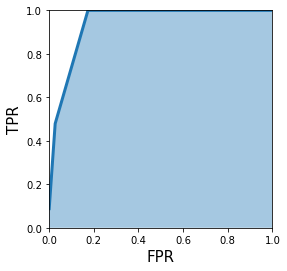

In [468]:
plt.figure(figsize=(4,4))
plt.fill_between(tpr_fpr['FPR'],tpr_fpr['TPR'],alpha=.4)
plt.plot(tpr_fpr['FPR'],tpr_fpr['TPR'],lw=3)
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)

This curve is called Receiver Operating Characteristic Curve. Our objective is to calculate area under this curve. We more oftenly use this when we have skewed targets.

This metric is also known as Area under ROC or AUC.  We can calculate AUC via metrics.roc_auc_score(yt,ypred)

In [469]:
metrics.roc_auc_score(mod.y_train,ypred)

0.9425655155075009

In [470]:
tpr_fpr

,Threshold,TPR,FPR
0,0.00,1.000000,1.000000
1,0.10,1.000000,0.173638
2,0.20,1.000000,0.173638
3,0.25,1.000000,0.173638
4,0.30,1.000000,0.173638
5,0.35,0.479065,0.026773
6,0.40,0.479065,0.026773
7,0.45,0.479065,0.026773
8,0.50,0.479065,0.026773
9,0.55,0.479065,0.026773


AUC values range from 0 to 1, intution behind values are :

    - AUC = 1 : it implies that you have a perfect model, which is like you are in your dream world. Most of the time it means you have made some mistake with validation and should revisit data processing and validation pipeline of yours. 
    
    - AUC = 0 : it implies that your model is a very bad model. Try inverting the probabilities for the predictions, for example,if your probability for the positive class , i.e Response = 1, is p, try substituting with 1-p. This kin of AUC may also mean that there is some problem with your validation or data processing
    
    - AUC = .5 : it implies that your predictions are random. So, for binary classification problem, if i predict all targets as .5, I will get AUC of .5
    
AUC values between 0-.5 imply that yyour model is worse than random. Most of the time it is because you inverted the classes. If you try to invert your predictions, your AUC might become more than .5. AUC value closer to 1 is considered good.

What does AUC convey here :

Suppose you get an AUC of .94 when you build a model to detect if customer is going to avail vehicle insurance with health insurance or not . This means that if you select a random row (dataset row) from your dataset of a person who opts for vehicle insurance along with health, i.e where Response=1 and another random row where person does not opt, i.e Response=0, then the row where Response=1 will rank higher than a row where Response=0 with a probability of .94

The ROC curve will tell you how threshold impacts False Positive Rate and True Positive Rate, i.e True Positives and False Positives. If you do not want to have too many false positive, you should have high threshold. This will however give you more false negatives.

Here you can choose threshold as .35 you are not having too many false positives and not loosing much in true positives. Though you will have same impact in .5 as threshold for this study